In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [291]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [4]:
import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder

In [320]:
from networks import WMAutoencoder, WM_VAE

In [6]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [7]:
import h5py

In [10]:
# BATCH_SIZE = 512
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [58]:
class MineRlImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.loader = None
        with h5py.File(self.path, 'r') as f:
            self.size = len(f['pov'])
        self.pov = None

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.loader is None:
            self.loader = h5py.File(self.path, 'r')
            self.pov = self.loader['pov']
        image = self.pov[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [59]:
dataset = MineRlImageDataset("data/obtain_diamond.hdf5")

In [60]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [61]:
train_features = next(iter(train_dataloader))

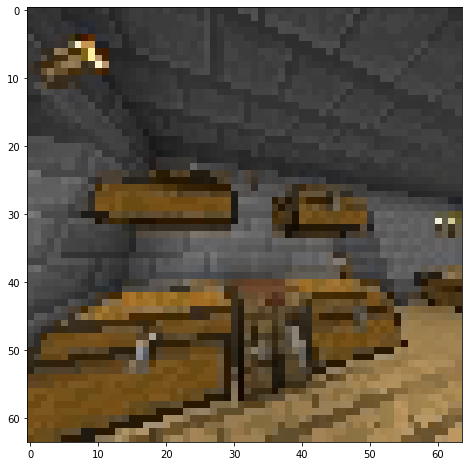

In [62]:
plt.imshow(train_features[9])

In [63]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [64]:
train_features = next(iter(train_dataloader))

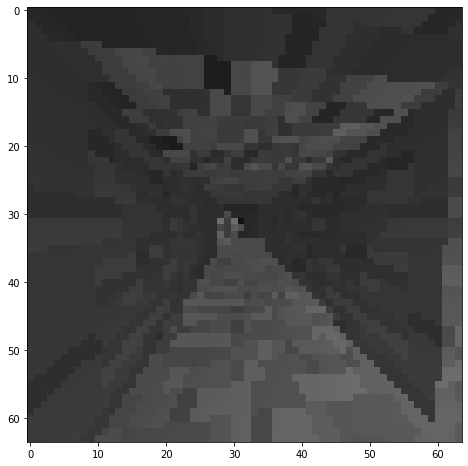

In [65]:
plt.imshow(train_features[19])

In [176]:
from pytorch_msssim import ssim
def vae_ssim_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = 1 - ssim(inputs, outputs, data_range=1, size_average=True, nonnegative_ssim=True, win_size=5)
    kl = autoencoder.kld_loss(mu, logvar) * .0
    return recon + kl, recon, kl

In [298]:
def vae_mixed_ssim_loss(inputs, outputs, latents):
    z, mu, logvar = latents
    recon = 0.1 * (1 - ssim(inputs, outputs, data_range=1, size_average=True, nonnegative_ssim=True, win_size=5)) + F.l1_loss(inputs, outputs)
    kl = autoencoder.kld_loss(mu, logvar) * .0
    return recon + kl, recon, kl

In [337]:
loss_func = vae_mixed_ssim_loss

In [370]:
model = WM_VAE(256).cuda()

In [371]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [302]:
def train_batch(inputs, model, optimizer, loss_func):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, latents = model(inputs)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    loss = loss_func(inputs, outputs, latents)
    if isinstance(loss, tuple):
        loss[0].backward()
    else:
        loss.backward()
    
#     plot_grad_flow(model.named_parameters())

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

In [372]:
losses = []
raw_losses = []
recons = []
kls = []

In [237]:
from minerl.data import BufferedBatchIter

In [238]:
data = minerl.data.make(
    'MineRLObtainDiamond-v0', "data")
bbi = BufferedBatchIter(data, buffer_target_size=60000)

Process ForkPoolWorker-409:
Process ForkPoolWorker-410:
Process ForkPoolWorker-412:
Process ForkPoolWorker-411:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multip

In [239]:
iterator = bbi.buffered_batch_iter(batch_size=1, num_epochs=1)

In [220]:
total = 0

In [114]:
class MineRlImageDataset(Dataset):
    def __init__(self, transform=None):
        initial_size = 12500504
        self.transform = transform
        self.pov = np.memmap('data/pov.npy', dtype='uint8', mode='r', shape=(initial_size, 64, 64, 3))


    def __len__(self):
        return self.pov.shape[0]

    def __getitem__(self, idx):
        image = self.pov[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [304]:
class MineRlImageDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        initial_size = 1916597
        self.transform = transform
        self.pov = np.memmap(base_dir + '/pov.npy', dtype='uint8', mode='r', shape=(initial_size, 64, 64, 3))


    def __len__(self):
        return self.pov.shape[0]

    def __getitem__(self, idx):
        image = self.pov[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [241]:
dataset = MineRlImageDataset("data/npy_obtain_diamond")

In [242]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [243]:
train_features = next(iter(train_dataloader))

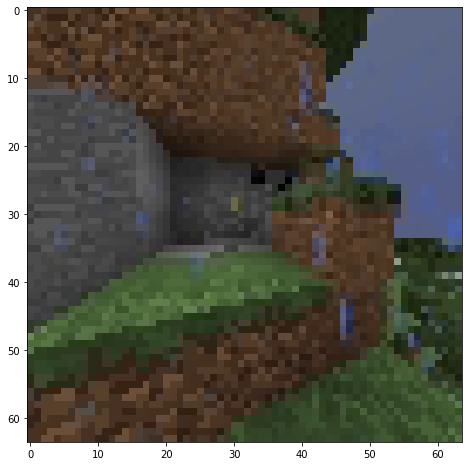

In [244]:
plt.imshow(train_features[10])

In [373]:
loss_steps = 50
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    with tqdm(enumerate(train_dataloader, 0), unit="batch") as t:
        for i, data in t:
            # get the inputs
    #         current_state, action, reward, next_state, done = data
            image = data.permute(0, 3, 1, 2).cuda() / 255

    #         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
            full_loss = train_batch(image, model, optimizer, loss_func)

            if isinstance(full_loss, tuple):
                loss = full_loss[0].item()
                raw_losses.append(loss)
                recons.append(full_loss[1].item())
                kls.append(full_loss[2].item())
            else:
                loss = full_loss.item()
                raw_losses.append(loss)


    #         if loss is None or torch.isnan(loss).any():
    #             print("There's a NaN loss!")
    #             from IPython.core.debugger import Pdb; Pdb().set_trace()
    #             break



            # print statistics
            running_loss += loss
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                losses.append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0

7487batch [08:08, 15.33batch/s, [1,  7450] loss: 0.07170371]
7487batch [08:09, 15.29batch/s, [2,  7450] loss: 0.06687324]
7487batch [08:09, 15.29batch/s, [3,  7450] loss: 0.06347261]
7487batch [08:09, 15.28batch/s, [4,  7450] loss: 0.06063854]
7487batch [08:09, 15.28batch/s, [5,  7450] loss: 0.05834606]
7487batch [08:10, 15.28batch/s, [6,  7450] loss: 0.05753264]
7487batch [08:10, 15.28batch/s, [7,  7450] loss: 0.05589882]
7487batch [08:10, 15.28batch/s, [8,  7450] loss: 0.05482856]
7487batch [08:10, 15.27batch/s, [9,  7450] loss: 0.05377284]
7487batch [08:10, 15.28batch/s, [10,  7450] loss: 0.05311385]


In [362]:
loss_func

<function __main__.vae_mixed_ssim_loss(inputs, outputs, latents)>

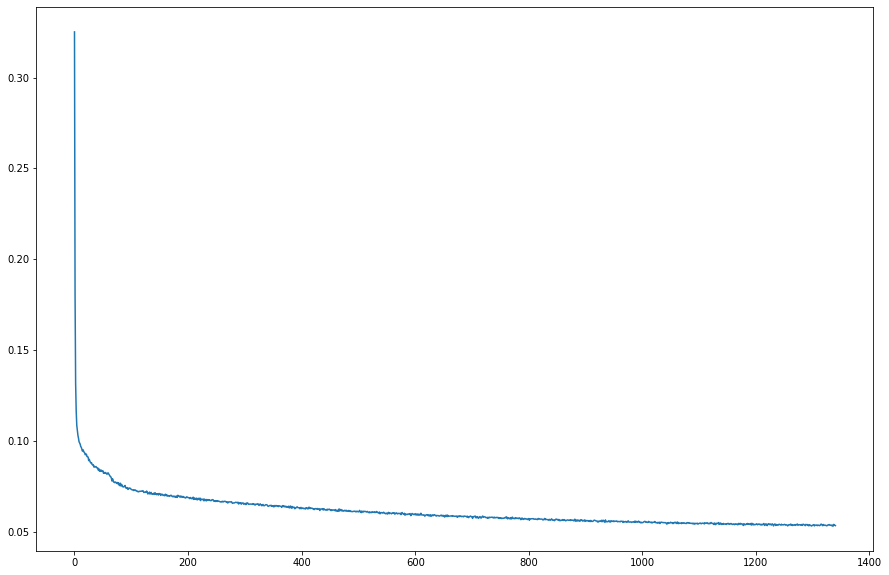

In [363]:
plt.plot(losses)

In [248]:
weird_image = image

In [374]:
image = train_features.permute(0, 3, 1, 2).cuda() / 255

In [381]:
outputs, latents = model(image)
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)

8 is a good one, has water and lava

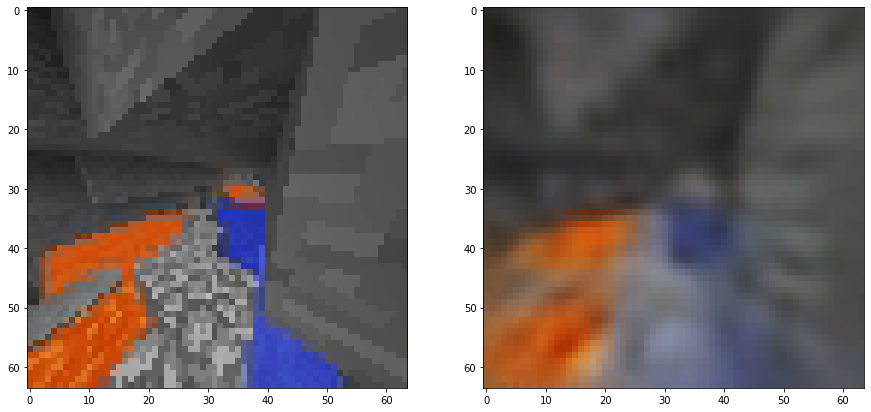

In [382]:
idx = 8
plt.subplot(1, 2, 1)
plt.imshow(image[idx].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)

plt.imshow(op[idx])

In [383]:
op.shape

(256, 64, 64, 3)

In [384]:
from delve import CheckLayerSat

In [385]:
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=model, device=image.device)    

added layer encoder-0
Skipping encoder-1
added layer encoder-2
Skipping encoder-3
added layer encoder-4
Skipping encoder-5
added layer encoder-6
Skipping encoder-7
added layer latent-mu
added layer latent-logvar
added layer unlatent
Skipping decoder-0
Skipping decoder-1
Skipping decoder-2
Skipping decoder-3
Skipping decoder-4
Skipping decoder-5
Skipping decoder-6
Skipping decoder-7


my_experiment_lsat_train_epoch_0.png


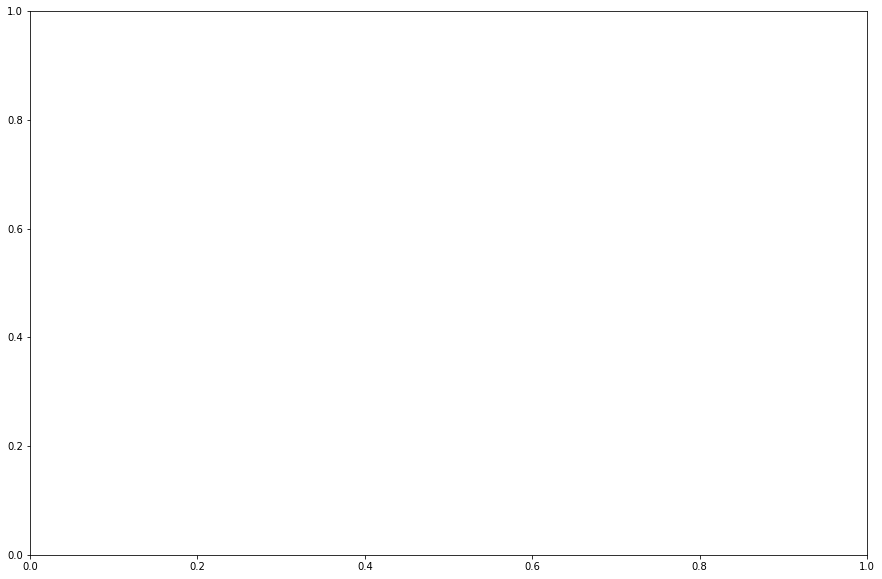

In [386]:
loss = train_batch(image, model, optimizer, loss_func)
tracker.add_saturations()

In [389]:
model.unlatent

Linear(in_features=256, out_features=1024, bias=True)